In [1]:
import warnings
warnings.filterwarnings("ignore")
import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import(
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,f1_score
)
from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
from datasets import Image as img
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomRotation,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
import torch 
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
image_dict = {}
from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []
for file in Path("../data/images/images").rglob("*.jpg"):
    label = file.parent.name 
    labels.append(label)
    file_names.append(str(file))

print(len(file_names), len(labels))
df = pd.DataFrame({"image": file_names, "label": labels})
print(df.shape)

70816 70816
(70816, 2)


In [5]:
df.head()

,image,label
0,..\data\images\images\train\angry\0.jpg,angry
1,..\data\images\images\train\angry\1.jpg,angry
2,..\data\images\images\train\angry\10.jpg,angry
3,..\data\images\images\train\angry\10002.jpg,angry
4,..\data\images\images\train\angry\10016.jpg,angry


In [6]:
y = df[['label']]
df = df.drop(columns=['label'],axis=1)
ros = RandomOverSampler(random_state=83)

df, y_resampled = ros.fit_resample(df, y)

del y
df['label'] = y_resampled

del y_resampled
gc.collect()
print(df.shape)

(125846, 2)


In [7]:
dataset = Dataset.from_pandas(df).cast_column("image", img())

In [8]:
labels_subset = labels[:5]
print("Labels subset:", labels_subset)

Labels subset: ['angry', 'angry', 'angry', 'angry', 'angry']


In [9]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy']

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Label to ID mapping: {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}
ID to Label mapping: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'}


In [10]:
from datasets import ClassLabel
ClassLabel = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_labels(example):
    example['label'] = ClassLabel.str2int(example['label'])
    return example 
dataset = dataset.map(map_labels, batched=True)

dataset = dataset.cast_column("label", ClassLabel)
dataset = dataset.train_test_split(test_size = 0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/125846 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/125846 [00:00<?, ? examples/s]

In [22]:
model = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model)
image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size['height']
print("size:", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size,size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        RandomHorizontalFlip(0.5),
        ToTensor(),
        normalize,
    ]
)
_val_transforms = Compose(
    [
        Resize((size,size)),
        ToTensor(),
        normalize,
    ]
)

def train_transform(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

size: 224


In [12]:
train_data.set_transform(train_transform)
test_data.set_transform(val_transforms)

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [23]:
model = ViTForImageClassification.from_pretrained(model, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

for param in model.vit.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.vit.encoder.layer[-4:].parameters():
    param.requires_grad = True
    
model.to(device)

print(model.num_parameters(only_trainable=True) / 1e6)
print(f"Model is on device: {next(model.parameters()).device}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


28.356871
Model is on device: cuda:0


In [15]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {"accuracy": acc_score}  

In [24]:
metric_name = 'accuracy'
model_name = 'facial_emotions_image_detection'
num_train_epochs = 30

if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU Memory: {gpu_memory:.1f} GB")

args = TrainingArguments(
    output_dir=model_name,
    logging_dir = './logs',
    eval_strategy="epoch",
    learning_rate= 5e-5,
    lr_scheduler_type='cosine',
    warmup_ratio=0.1,
    per_device_eval_batch_size= 32 if gpu_memory > 8 else 8,
    per_device_train_batch_size= 64 if gpu_memory > 8 else 32,
    num_train_epochs = num_train_epochs,
    weight_decay= 0.02,
    warmup_steps = 100,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",
    eval_steps=500,
    logging_steps=100,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    fp16=True,
)

GPU Memory: 6.4 GB


In [25]:
from transformers import EarlyStoppingCallback

callback = EarlyStoppingCallback(
    early_stopping_patience=8,
    early_stopping_threshold=0.06
)
trainer = Trainer(
    model,
    args,
    train_dataset = train_data,
    eval_dataset = test_data,
    data_collator = collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    callbacks=[callback],
)

In [26]:
trainer.evaluate()

{'eval_loss': 1.9411166906356812,
 'eval_model_preparation_time': 0.0036,
 'eval_accuracy': 0.18152923180833946,
 'eval_runtime': 234.1423,
 'eval_samples_per_second': 214.993,
 'eval_steps_per_second': 26.877}

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,1.014400,1.034392,0.003600,0.617056
2,0.873500,0.922285,0.003600,0.662051
3,0.768200,0.865786,0.003600,0.679811
4,0.651000,0.824593,0.003600,0.701106
5,0.629500,0.806944,0.003600,0.698305
6,0.542400,0.773014,0.003600,0.713383
7,0.471100,0.760681,0.003600,0.725938
8,0.416900,0.713383,0.003600,0.740917
9,0.360600,0.723185,0.003600,0.742685
10,0.358700,0.693883,0.003600,0.754504


TrainOutput(global_step=23600, training_loss=0.6465182027978412, metrics={'train_runtime': 9686.6472, 'train_samples_per_second': 233.849, 'train_steps_per_second': 7.309, 'total_flos': 5.851449871550244e+19, 'train_loss': 0.6465182027978412, 'epoch': 10.0})

In [ ]:
trainer.model.save_pretrained("emotion_classification_trained_3",safe_serialization=False)

if hasattr(trainer, 'feature_extractor'):
    trainer.feature_extractor.save_pretrained("emotion_classification_trained_3")

else :
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    processor.save_pretrained("emotion_classification_trained_3")

In [33]:
trainer.evaluate()

AttributeError: 'float' object has no attribute 'compute'

In [39]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.9549954533576965, 'test_model_preparation_time': 0.002, 'test_accuracy': 0.657998768350583, 'test_runtime': 347.2539, 'test_samples_per_second': 144.963, 'test_steps_per_second': 18.122}


Accuracy: 0.6580
F1 Score: 0.6569


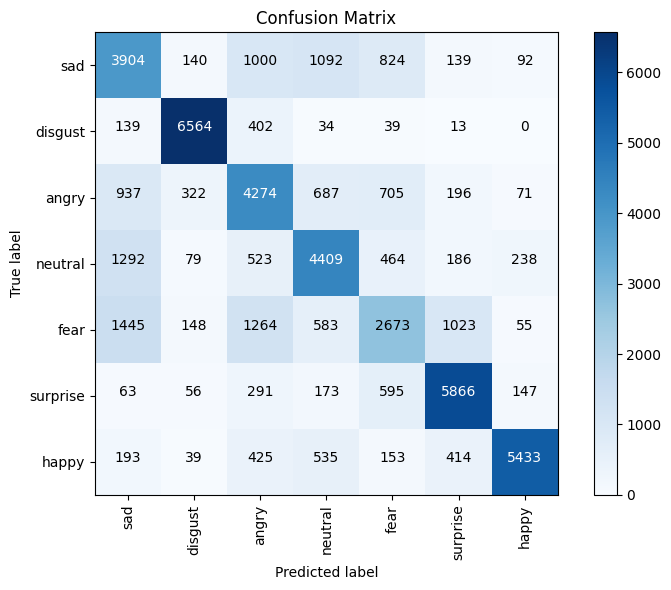


Classification report:

              precision    recall  f1-score   support

         sad     0.4897    0.5429    0.5149      7191
     disgust     0.8933    0.9128    0.9030      7191
       angry     0.5226    0.5943    0.5561      7192
     neutral     0.5868    0.6131    0.5997      7191
        fear     0.4902    0.3717    0.4228      7191
    surprise     0.7485    0.8157    0.7807      7191
       happy     0.9001    0.7554    0.8214      7192

    accuracy                         0.6580     50339
   macro avg     0.6616    0.6580    0.6569     50339
weighted avg     0.6616    0.6580    0.6569     50339



In [43]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
   
    plt.figure(figsize=figsize)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

VALIDATION

In [24]:
model = ViTForImageClassification.from_pretrained("emotion_classification_trained")
processor = ViTImageProcessor.from_pretrained("emotion_classification_trained")
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [25]:
if hasattr(model.config, 'id2label') and model.config.id2label:
    id2label = model.config.id2label
else:
    id2label = {
        0: "angry", 1: "disgust", 2: "fear", 3: "happy",
        4: "neutral", 5: "sad", 6: "surprise"
    }

print(f"Model loaded successfully!")
print(f"Number of emotion classes: {len(id2label)}")
print(f"Emotion labels: {list(id2label.values())}")

Model loaded successfully!
Number of emotion classes: 7
Emotion labels: ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy']


In [26]:
resized_folder = "../data/images/resized_samples"
def load_images_from_folder(folder_path):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}
    image_paths = []
    
    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_paths.append(os.path.join(folder_path, filename))
    
    return image_paths

def predict_single_image(image_path, save_resized_sample=False):
    try:
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            return None, None, None
            
        try:
            image = Image.open(image_path)
        except Exception as img_error:
            print(f"Error opening image {image_path}: {img_error}")
            try:
                import PIL.Image
                image = PIL.Image.open(image_path)
            except Exception as alt_error:
                print(f"Alternative PIL also failed: {alt_error}")
                return None, None, None
        
        image = image.convert('RGB')
        
        original_size = image.size
        
        image_48x48 = image.resize((48, 48), Image.Resampling.LANCZOS)
        
        if save_resized_sample:
            filename = os.path.basename(image_path)
            name, ext = os.path.splitext(filename)
            resized_filename = f"{name}_48x48{ext}"
            resized_path = os.path.join(resized_folder, resized_filename)
            image_48x48.save(resized_path)
            print(f"Saved resized sample: {resized_path}")
        
        inputs = processor(images=image_48x48, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
        
        probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
        predicted_class_id = logits.argmax().item()
        predicted_label = id2label[predicted_class_id]
        confidence = probabilities[predicted_class_id].item()
        
        return predicted_label, confidence, probabilities, original_size
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        print(f"Error type: {type(e)}")
        return None, None, None, None


def print_emotion_distribution(emotion_distribution, folder_name=""):
    if folder_name:
        print(f"\n=== Emotion Distribution for {folder_name} ===")
    else:
        print("\n=== Emotion Distribution ===")    
    sorted_emotions = sorted(emotion_distribution.items(), 
                           key=lambda x: x[1], reverse=True)
    
    for emotion, probability in sorted_emotions:
        print(f'"{emotion}": {probability:.2f}')

In [27]:
folder_path = "../data/images/asd/person_8"  
if not os.path.exists(folder_path):
    print(f"Folder {folder_path} not be found!")
else:
    print(f"Folder found: {folder_path}")

Folder found: ../data/images/asd/person_8


In [28]:
image_paths = load_images_from_folder(folder_path)
print(f"Found {len(image_paths)} images in the folder")

if image_paths:
    print("\nSample image files:")
    for i, path in enumerate(image_paths[:5]): 
        print(f"{i+1}. {os.path.basename(path)}")
    if len(image_paths) > 5:
        print(f"... and {len(image_paths) - 5} more images")

Found 2061 images in the folder

Sample image files:
1. PERSON_400051_face0.jpg
2. PERSON_400131_face0.jpg
3. PERSON_400421_face0.jpg
4. PERSON_400431_face0.jpg
5. PERSON_400441_face0.jpg
... and 2056 more images


In [29]:
print("Processing images...")

all_probabilities = []
successful_predictions = 0
failed_predictions = 0
save_sample_counter = 0
max_samples_to_save = 0

for i, image_path in enumerate(image_paths):
    if i % 10 == 0:  
        print(f"Processing image {i+1}/{len(image_paths)}")
    
    save_resized = save_sample_counter < max_samples_to_save
    
    result = predict_single_image(image_path, save_resized_sample=save_resized)
    
    if len(result) == 4 and result[0] is not None:
        _, _, probabilities, original_size = result
        all_probabilities.append(probabilities.numpy())
        successful_predictions += 1
        
        if save_resized:
            save_sample_counter += 1
            print(f"  Sample {save_sample_counter}: {os.path.basename(image_path)} - Original: {original_size}, Resized: 48x48")
    else:
        failed_predictions += 1

print(f"\nProcessing completed:")
print(f"- Successful: {successful_predictions}")
print(f"- Failed: {failed_predictions}")
print(f"- Resized samples saved: {min(save_sample_counter, max_samples_to_save)}")

if all_probabilities:
    avg_probabilities = np.mean(all_probabilities, axis=0)    
    emotion_distribution_avg = {}
    for class_id, avg_prob in enumerate(avg_probabilities):
        emotion_label = id2label[class_id]
        emotion_distribution_avg[emotion_label] = float(avg_prob)
    
    print_emotion_distribution(emotion_distribution_avg, f"Average Probabilities Method (48x48 Resize)")
else:
    print("No successful predictions made!")

Processing images...
Processing image 1/2061
Processing image 11/2061
Processing image 21/2061
Processing image 31/2061
Processing image 41/2061
Processing image 51/2061
Processing image 61/2061
Processing image 71/2061
Processing image 81/2061
Processing image 91/2061
Processing image 101/2061
Processing image 111/2061
Processing image 121/2061
Processing image 131/2061
Processing image 141/2061
Processing image 151/2061
Processing image 161/2061
Processing image 171/2061
Processing image 181/2061
Processing image 191/2061
Processing image 201/2061
Processing image 211/2061
Processing image 221/2061
Processing image 231/2061
Processing image 241/2061
Processing image 251/2061
Processing image 261/2061
Processing image 271/2061
Processing image 281/2061
Processing image 291/2061
Processing image 301/2061
Processing image 311/2061
Processing image 321/2061
Processing image 331/2061
Processing image 341/2061
Processing image 351/2061
Processing image 361/2061
Processing image 371/2061
Pr

In [30]:
emotion_counts = Counter()
successful_predictions = 0

for i, image_path in enumerate(image_paths):
    result = predict_single_image(image_path, save_resized_sample=False)
    if len(result) == 4 and result[0] is not None:
        predicted_label, _, _, _ = result
        emotion_counts[predicted_label] += 1
        successful_predictions += 1

if emotion_counts:
    emotion_distribution_vote = {}
    total_predictions = sum(emotion_counts.values())
    
    for emotion in id2label.values():
        emotion_distribution_vote[emotion] = 0.0
    
    for emotion, count in emotion_counts.items():
        emotion_distribution_vote[emotion] = count / total_predictions
    
    print_emotion_distribution(emotion_distribution_vote, "Vote Count Method (48x48 Resize)")
    
    print(f"\nRaw vote counts (out of {total_predictions} successful predictions):")
    for emotion, count in sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{emotion}: {count} votes")



=== Emotion Distribution for Vote Count Method (48x48 Resize) ===
"sad": 0.93
"neutral": 0.05
"happy": 0.01
"angry": 0.01
"fear": 0.00
"disgust": 0.00
"surprise": 0.00

Raw vote counts (out of 2061 successful predictions):
sad: 1910 votes
neutral: 105 votes
happy: 18 votes
angry: 12 votes
fear: 9 votes
disgust: 7 votes


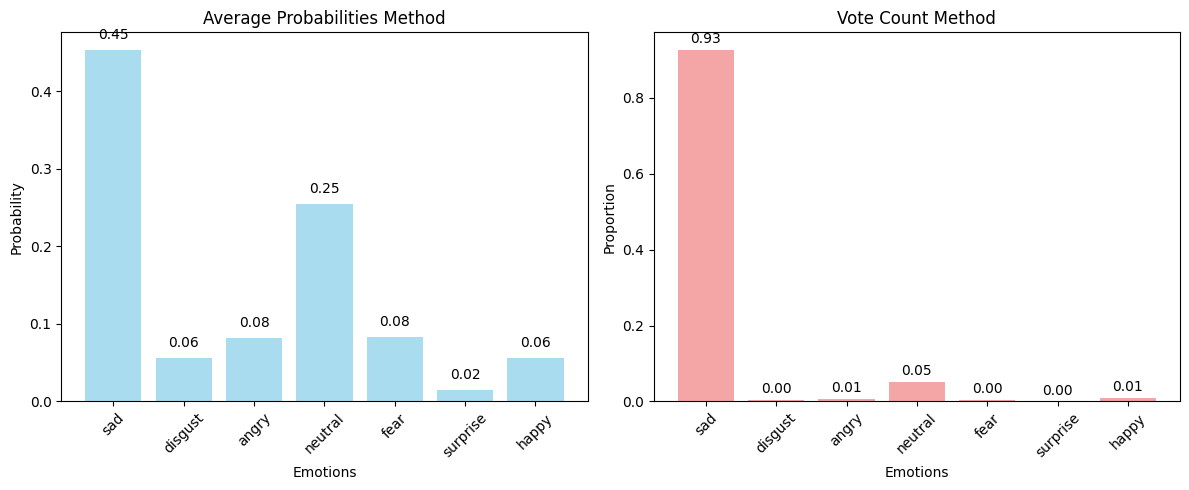

In [31]:
if 'emotion_distribution_avg' in locals():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    emotions = list(emotion_distribution_avg.keys())
    probabilities = list(emotion_distribution_avg.values())
    
    bars1 = plt.bar(emotions, probabilities, color='skyblue', alpha=0.7)
    plt.title('Average Probabilities Method')
    plt.xlabel('Emotions')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')
    
    if 'emotion_distribution_vote' in locals():
        plt.subplot(1, 2, 2)
        emotions2 = list(emotion_distribution_vote.keys())
        probabilities2 = list(emotion_distribution_vote.values())
        
        bars2 = plt.bar(emotions2, probabilities2, color='lightcoral', alpha=0.7)
        plt.title('Vote Count Method')
        plt.xlabel('Emotions')
        plt.ylabel('Proportion')
        plt.xticks(rotation=45)
        
        for bar in bars2:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [32]:
sample_size = min(10, len(image_paths))
print(f"Showing detailed predictions for first {sample_size} images:")

detailed_results = []
for i in range(sample_size):
    image_path = image_paths[i]
    emotion, confidence, all_probs = predict_single_image(image_path)
    
    if emotion:
        filename = os.path.basename(image_path)
        print(f"\n{i+1}. {filename}")
        print(f"   Predicted: {emotion} (confidence: {confidence:.3f})")
        
        probs_dict = {id2label[j]: prob.item() for j, prob in enumerate(all_probs)}
        top_3 = sorted(probs_dict.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"   Top 3: {top_3[0][0]}({top_3[0][1]:.3f}), {top_3[1][0]}({top_3[1][1]:.3f}), {top_3[2][0]}({top_3[2][1]:.3f})")
        
        detailed_results.append({
            'image': filename,
            'predicted_emotion': emotion,
            'confidence': confidence
        })

Showing detailed predictions for first 10 images:


ValueError: too many values to unpack (expected 3)

In [ ]:
import json
save_folder_path = "../result"
person = "Person_8"
if not os.path.exists(save_folder_path): 
    print("path not exist")
    
if 'emotion_distribution_avg' in locals():
    results_to_save = {
        'folder_name': os.path.basename(save_folder_path),
        'total_images': len(image_paths),
        'successful_predictions': successful_predictions,
        'failed_predictions': failed_predictions,
        'emotion_distribution_avg_probabilities': emotion_distribution_avg
    }
    
    if 'emotion_distribution_vote' in locals():
        results_to_save['emotion_distribution_vote_count'] = emotion_distribution_vote

    output_filename = f"{person}_{os.path.basename(save_folder_path)}.json"
    with open(output_filename, 'w') as f:
        json.dump(results_to_save, f, indent=2)
    
    print(f"\nResults saved to: {output_filename}")

    text_filename = f"{person}_{os.path.basename(save_folder_path)}.txt"
    with open(text_filename, 'w') as f:
        f.write(f"Emotion Validation Results for {os.path.basename(folder_path)}\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Total images processed: {len(image_paths)}\n")
        f.write(f"Successful predictions: {successful_predictions}\n")
        f.write(f"Failed predictions: {failed_predictions}\n\n")
        
        f.write("Average Probabilities Method:\n")
        for emotion, prob in sorted(emotion_distribution_avg.items(), key=lambda x: x[1], reverse=True):
            f.write(f'"{emotion}": {prob:.2f}\n')
    
    print(f"Text results saved to: {text_filename}")


Results saved to: Person_8_result.json
Text results saved to: Person_8_result.txt
